In [1]:
from environment import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
m1 = Machine(name = 'M1', payout = [[0.10, 0.50],[0.40, 0.20]])
m2 = Machine(name = 'M2', payout = [[0.50, 0.10],[0.20, 0.40]])

In [5]:
np.mean([m1.play(Player(0.5, 0.5,'player1')) for i in range(1000)])

0.309

In [6]:
l = []
for _ in range(1000):
    p1 = Player(0.5, 0.5, 'player1')
    m = None
    if p1.d == 1:
        m = m1 if p1.b == 1 else m2
    else:
        m = m2 if p1.b == 1 else m1
    l.append(m.play(p1))
np.mean(l)

0.147

In [7]:
def get_natural_m(player):
    d, b = player.d, player.b
    m = None
    if d == 0:
        m = m1 if b == 0 else m2
    else:
        m = m2 if b == 0 else m1
    return m

In [8]:
def get_optimal_m(player):
    d, b = player.d, player.b
    m = None
    if d == 0:
        m = m2 if b == 0 else m1
    else:
        m = m1 if b == 0 else m2
    return m

In [9]:
episodes = 5000

### Greedy / Observation / Intution

In [10]:
m1_r,m2_r  = [], []
cumm_regret = []

for _ in range(episodes):
    p = Player(0.5, 0.5)    
    m = get_natural_m(p)
    reward = m.play(p)
    t = m1_r if m == m1 else m2_r
    t.append(reward)        
    optimal_m = get_optimal_m(p)
    regret = abs(optimal_m.get_payout(p.d, p.b) - m.get_payout(p.d, p.b))
    
    if len(cumm_regret) > 0:
        cumm_regret.append(cumm_regret[-1] + regret)
    else:
        cumm_regret.append(regret)

In [11]:
print("M1 estimated reward : ", np.mean(m1_r))
print("M2 estimated reward : ", np.mean(m2_r))

M1 estimated reward :  0.14806110458284372
M2 estimated reward :  0.1491622394769105


### Eps-Greedy

In [12]:
m1_r, m2_r  = [1e-3], [1e-3]

cumm_regret_eps = []
epsilon = 0.5
prob_greedy = []

for _ in range(episodes):
    p = Player(0.5, 0.5)    
    m1_r_m, m2_r_m = np.mean(m1_r), np.mean(m2_r)
    idx = np.argmax([m1_r_m, m2_r_m])
    m = [m1,m2][idx]
    if np.random.random() < epsilon:
        m = np.random.choice([m1,m2], size=1)[0]
    reward = m.play(p)
    
    t = m1_r if m == m1 else m2_r
    t.append(reward)   
    
    optimal_m = get_optimal_m(p)
    regret = optimal_m.get_payout(p.d, p.b) - m.get_payout(p.d, p.b)
    idx = 0 if optimal_m == m1 else 1
    prob = [m1_r_m, m2_r_m][idx]
    prob_greedy.append((prob/(m1_r_m + m2_r_m)))
    
    if len(cumm_regret_eps) > 0:
        cumm_regret_eps.append(cumm_regret_eps[-1] + regret)
    else:
        cumm_regret_eps.append(regret)

In [13]:
print("M1 estimated reward : ", np.mean(m1_r))
print("M2 estimated reward : ", np.mean(m2_r))

M1 estimated reward :  0.29424227528089886
M2 estimated reward :  0.3160986584684181


### UCB

In [14]:
m1_r, m2_r  = [1e-3], [1e-3]
cumm_regret_ucb = []
alpha = 20
prob_ucb = []

for episode in range(1, episodes):
    p = Player(0.5, 0.5) 
    
    Q_m1 = np.mean(m1_r) + ((alpha*np.log(episode))/(2*len(m1_r)))**0.5
    Q_m2 = np.mean(m2_r) + ((alpha*np.log(episode))/(2*len(m2_r)))**0.5
    
    idx = np.argmax([Q_m1, Q_m2])
    m = [m1,m2][idx]
    reward = m.play(p)

    t = m1_r if m == m1 else m2_r
    t.append(reward)   
    
    optimal_m = get_optimal_m(p)
    regret = optimal_m.get_payout(p.d, p.b) - m.get_payout(p.d, p.b)
    
    idx = 0 if optimal_m == m1 else 1
    prob = [m1_r_m, m2_r_m][idx]
    prob_ucb.append((prob/(m1_r_m + m2_r_m)))
    
    if len(cumm_regret_ucb) > 0:
        cumm_regret_ucb.append(cumm_regret_ucb[-1] + regret)
    else:
        cumm_regret_ucb.append(regret)

In [15]:
print("M1 estimated reward : ", np.mean(m1_r))
print("M2 estimated reward : ", np.mean(m2_r))

M1 estimated reward :  0.28383172231985937
M2 estimated reward :  0.30018385321100916


### Thompson Sampling

In [16]:
m1_r = {'a':1, 'b':1}
m2_r = {'a':1, 'b':1}

cumm_regret_thompson = []
prob_thm = []

for episode in range(episodes):
    p = Player(0.5, 0.5) 
    
    Q_m1 = np.random.beta(m1_r['a'], m1_r['b'])
    Q_m2 = np.random.beta(m2_r['a'], m2_r['b'])
    
    idx = np.argmax([Q_m1, Q_m2])
    m = [m1,m2][idx]
    reward = m.play(p)

    t = m1_r if m == m1 else m2_r
    if reward == 1:
        t['a'] += 1
    else:
        t['b'] += 1
    
    optimal_m = get_optimal_m(p)
    regret = optimal_m.get_payout(p.d, p.b) - m.get_payout(p.d, p.b)
    idx = 0 if optimal_m == m1 else 1
    prob = [m1_r_m, m2_r_m][idx]
    prob_thm.append((prob/(m1_r_m + m2_r_m)))
    
    if len(cumm_regret_thompson) > 0:
        cumm_regret_thompson.append(cumm_regret_thompson[-1] + regret)
    else:
        cumm_regret_thompson.append(regret)

In [17]:
print("M1 estimated reward : ", np.random.beta(m1_r['a'], m1_r['b']))
print("M2 estimated reward : ", np.random.beta(m2_r['a'], m2_r['b']))

M1 estimated reward :  0.29078596440043986
M2 estimated reward :  0.3279071989233925


## Counterfactual Thompson Sampling

In [18]:
beta_priors = {
    'm1' : {'m1': {'a':1, 'b':1}, 'm2': {'a':1, 'b':1}}, 
    'm2' : {'m1': {'a':1, 'b':1}, 'm2': {'a':1, 'b':1}}
}

cumm_regret_c_thompson = []
prob_count_thm = []

for episode in range(episodes):
    p = Player(0.5, 0.5) 
    intent_m = get_natural_m(p)
    intent_m, opp_m = ('m1', 'm2') if intent_m == m1 else ('m2', 'm1')
    beta_ = beta_priors[intent_m]
    beta_opp = beta_priors[opp_m]
    
    Q_m1 = np.random.beta(beta_['m1']['a'], beta_['m1']['b'])
    Q_m2 = np.random.beta(beta_['m2']['a'], beta_['m2']['b'])

    idx = np.argmax([Q_m1, Q_m2])
    m = [m1,m2][idx]
    reward = m.play(p)

    t = beta_['m1'] if m == m1 else beta_['m2']
    if reward == 1:
        t['a'] += 1
    else:
        t['b'] += 1
    T_m1 = np.random.beta(beta_opp['m1']['a'], beta_opp['m1']['b'])
    T_m2 = np.random.beta(beta_opp['m2']['a'], beta_opp['m2']['b'])
    
    optimal_m = get_optimal_m(p)
    regret = optimal_m.get_payout(p.d, p.b) - m.get_payout(p.d, p.b)
    idx = 0 if optimal_m == m1 else 1
    prob = [Q_m1,Q_m2][idx]
    prob_count_thm.append((prob/(Q_m1 + Q_m2)))
    
    if len(cumm_regret_c_thompson) > 0:
        cumm_regret_c_thompson.append(cumm_regret_c_thompson[-1] + regret)
    else:
        cumm_regret_c_thompson.append(regret)

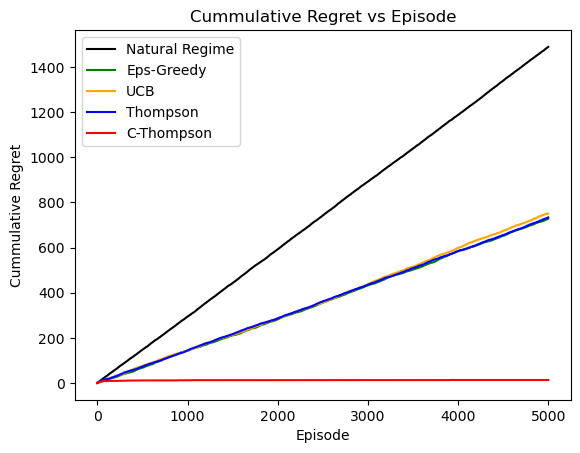

In [19]:
plt.plot(cumm_regret, label='Natural Regime',c = 'black')
plt.plot(cumm_regret_eps, label='Eps-Greedy', c='green')
plt.plot(cumm_regret_ucb, label='UCB', c = 'orange')
plt.plot(cumm_regret_thompson, label='Thompson', c = 'blue')
plt.plot(cumm_regret_c_thompson, label='C-Thompson', c= 'red')
plt.xlabel('Episode')
plt.ylabel('Cummulative Regret')
plt.title('Cummulative Regret vs Episode')
plt.legend()
plt.show()

In [20]:
def take_moving_averege(arr, window_size = 100):
    i, moving_averages = 0, []
    for i in range(len(arr)):
        low = 0 if i <= window_size else i - window_size
        moving_averages.append(np.mean(arr[low : i]))
    return moving_averages

/Users/sohamdandapath/miniconda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sohamdandapath/miniconda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


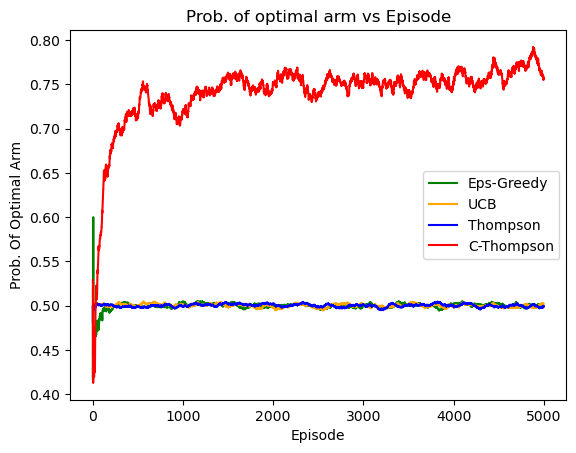

In [21]:
plt.plot(take_moving_averege(prob_greedy), label='Eps-Greedy', c = 'green')
plt.plot(take_moving_averege(prob_ucb), label='UCB', c = 'orange')
plt.plot(take_moving_averege(prob_thm), label='Thompson', c = 'blue')
plt.plot(take_moving_averege(prob_count_thm), label='C-Thompson', c='red')
plt.xlabel('Episode')
plt.ylabel('Prob. Of Optimal Arm')
plt.title('Prob. of optimal arm vs Episode')
plt.legend()
plt.show()